In [26]:
import numpy as np
import pandas as pd

In [27]:
%pip install conect2py

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [124]:
import time

# MODEL FUNCTIONS
from conect2py.models import TAC
from conect2py.models import AutoTAC

# RUN FUNCTIONS
from conect2py.run.single import print_run_details, run_single_online, run_single_offline
from conect2py.run.multiple import run_multiple_instances, get_optimal_params, display_multirun_optimal_values, run_optimal_combination

# UTILS FUNCTIONS
from conect2py.utils.format_save import create_param_combinations, create_compressor_list, create_eval_df 
from conect2py.utils.metrics import get_compression_report, print_compression_report, calc_statistics
from conect2py.utils.plots import plot_curve_comparison, plot_dist_comparison, plot_multirun_metric_results 


In [29]:
# define the dictionary to hold the experiment results
exp_compression_report = {}
exp_statistics_report = {}

In [30]:
# read csv file
df = pd.read_csv('Data/gasolina_2023_concatenado.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889 entries, 0 to 30888
Data columns (total 88 columns):
 #   Column                                                Non-Null Count  Dtype  
---  ------                                                --------------  -----  
 0   GPS Time                                              30889 non-null  object 
 1    Device Time                                          30889 non-null  object 
 2    Longitude                                            30889 non-null  float64
 3    Latitude                                             30889 non-null  float64
 4   GPS Speed (Meters/second)                             30889 non-null  float64
 5    Horizontal Dilution of Precision                     30889 non-null  float64
 6    Altitude                                             30889 non-null  float64
 7    Bearing                                              30889 non-null  float64
 8    G(x)                                                 30

In [31]:
print(df.columns.tolist())

['GPS Time', ' Device Time', ' Longitude', ' Latitude', 'GPS Speed (Meters/second)', ' Horizontal Dilution of Precision', ' Altitude', ' Bearing', ' G(x)', ' G(y)', ' G(z)', ' G(calibrated)', ' Absolute Throttle Position B(%)', 'Acceleration Sensor(Total)(g)', 'Acceleration Sensor(X axis)(g)', 'Acceleration Sensor(Y axis)(g)', 'Acceleration Sensor(Z axis)(g)', 'Accelerator PedalPosition D(%)', 'Accelerator PedalPosition E(%)', 'Air Fuel Ratio(Commanded)(:1)', 'Alcohol Fuel Percentage(%)', 'Android device Battery Level(%)', 'Average trip speed(whilst moving only)(km/h)', 'Average trip speed(whilst stopped or moving)(km/h)', 'Barometer (on Android device)(mb)', 'Barometric pressure (from vehicle)(psi)', 'Catalyst Temperature (Bank 1 Sensor 1)(°C)', 'Commanded Equivalence Ratio(lambda)', 'CO₂ in g/km (Average)(g/km)', 'CO₂ in g/km (Instantaneous)(g/km)', 'Distance to empty (Estimated)(km)', 'Distance travelled since codes cleared(km)', 'Distance travelled with MIL/CEL lit(km)', 'Engine Co

In [163]:
df.shape

(30889, 88)

# First Experiment

In [32]:
data = df['Average trip speed(whilst stopped or moving)(km/h)']

In [33]:
sensor_data = pd.DataFrame({'Time': range(1, len(data) + 1), 'Avg_trip_speed': data })


In [34]:
sensor_data.describe()

,Time,Avg_trip_speed
count,30889.000000,30889.000000
mean,15445.000000,16.734863
std,8917.030569,4.178219
min,1.000000,0.690000
25%,7723.000000,14.170000
50%,15445.000000,17.030000
75%,23167.000000,19.700000
max,30889.000000,26.090000


## Visualizing the Raw Data

In [35]:
import seaborn as sns
from matplotlib import pyplot as plt

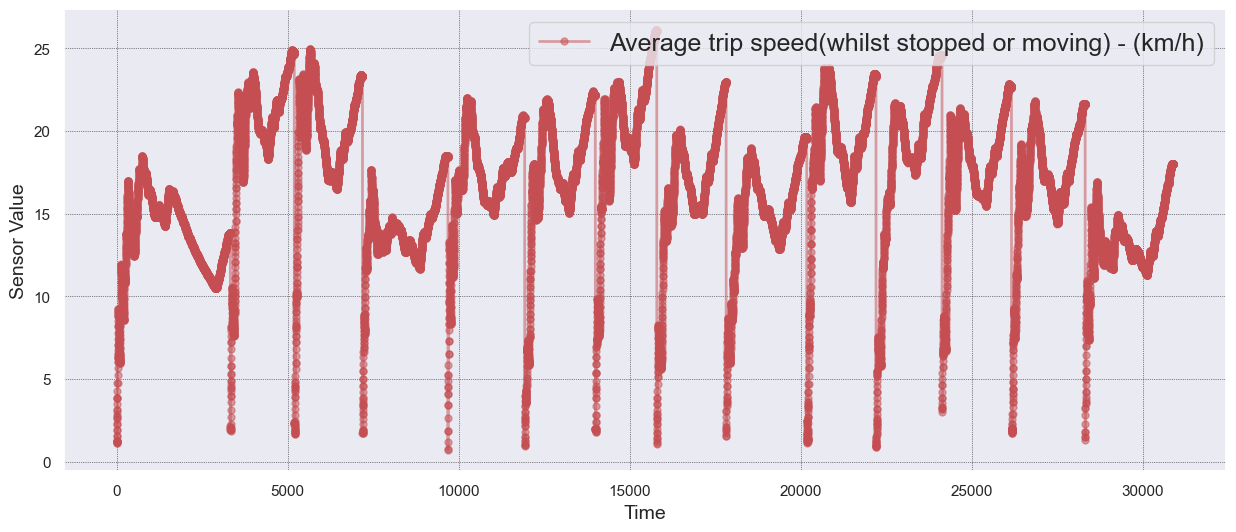

In [36]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.clear()
# define the curve1 and curve2 based on the params
curve1 = sensor_data['Avg_trip_speed']
curve1_name = 'Average trip speed(whilst stopped or moving) - (km/h)'
# plot the 2 curves
ax.plot(curve1, color='r', marker='o', linewidth=2, markersize=5, zorder=1, alpha=0.5, label=curve1_name)
#fig.suptitle('Average trip speed Visualization', fontsize=16)
ax.legend(fontsize=18, loc='upper right')
ax.set_ylabel('Sensor Value', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
plt.grid(color='k', linestyle=':', linewidth=0.5)

## Running TAC


Setting up the initial variables 

In [37]:
# first create a model name (not necessary but useful for saving)
model_name = 'TAC_TripSpeed_data'

# Create the params dictionary (actually necessary)
params = {
    'window_size': np.arange(2, 30, 1),
    'm': np.round(np.arange(0.1, 2.1, 0.1), 2),
}

# Clock time to create the param combination
combination_time_start = time.time()
# CPU time to create the param combination
combination_CPU_start = time.process_time()
param_combination = create_param_combinations(params)
combination_CPU_end = time.process_time()
combination_time_end = time.time()

print('Time to create the param combination: ', combination_time_end - combination_time_start)
print('CPU time to create the param combination: ', combination_CPU_end - combination_CPU_start)


Time to create the param combination:  0.0009944438934326172
CPU time to create the param combination:  0.015625


In [38]:
list_time_start = time.time()
list_CPU_start = time.process_time()
compressor_list = create_compressor_list(param_combination)
list_CPU_end = time.process_time()
list_time_end = time.time()

print('Time to create the compressor list: ', list_time_end - list_time_start)
print('CPU time to create the compressor list: ', list_CPU_end - list_CPU_start)

print(len(compressor_list), 'compressors created')

Time to create the compressor list:  0.002001047134399414
CPU time to create the compressor list:  0.0
560 compressors created


Run multiples TAC tests and save the results on a dataset

In [39]:
result_df_time_start = time.time()
result_df_CPU_start = time.process_time()
result_df = run_multiple_instances(compressor_list=compressor_list, 
                                param_list=param_combination,
                                series_to_compress=sensor_data['Avg_trip_speed'].dropna(),
                                cf_score_beta=2
                                )
result_df_CPU_end = time.process_time()
result_df_time_end = time.time()
 
print('Time to run the compressors: ', result_df_time_end - result_df_time_start)
print('CPU time to run the compressors: ', result_df_CPU_end - result_df_CPU_start)

result_df.head(8)

Time to run the compressors:  76.40441656112671
CPU time to run the compressors:  66.140625


,param,reduction_rate,reduction_factor,mse,rmse,nrmse,mae,psnr,ncc,cf_score
0,"(2, 0.1)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9824,0.9982,0.8031
1,"(2, 0.2)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9823,0.9982,0.8031
2,"(2, 0.3)",0.4507,1.8204,0.0648,0.2545,0.0609,0.0127,39.9823,0.9982,0.8031
3,"(2, 0.4)",0.4508,1.8209,0.0648,0.2545,0.0609,0.0127,39.9824,0.9982,0.8032
4,"(2, 0.5)",0.4511,1.8217,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8033
5,"(2, 0.6)",0.4518,1.8241,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8038
6,"(2, 0.7)",0.4518,1.8241,0.0648,0.2545,0.0609,0.0128,39.9823,0.9982,0.8038
7,"(2, 0.8)",0.5015,2.0060,0.4544,0.6741,0.1613,0.0407,31.5220,0.9869,0.8268


Visualize multirun results with a plot

In [40]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 560 entries, 0 to 559
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   param             560 non-null    object 
 1   reduction_rate    560 non-null    float64
 2   reduction_factor  560 non-null    float64
 3   mse               560 non-null    float64
 4   rmse              560 non-null    float64
 5   nrmse             560 non-null    float64
 6   mae               560 non-null    float64
 7   psnr              560 non-null    float64
 8   ncc               560 non-null    float64
 9   cf_score          560 non-null    float64
dtypes: float64(9), object(1)
memory usage: 48.1+ KB


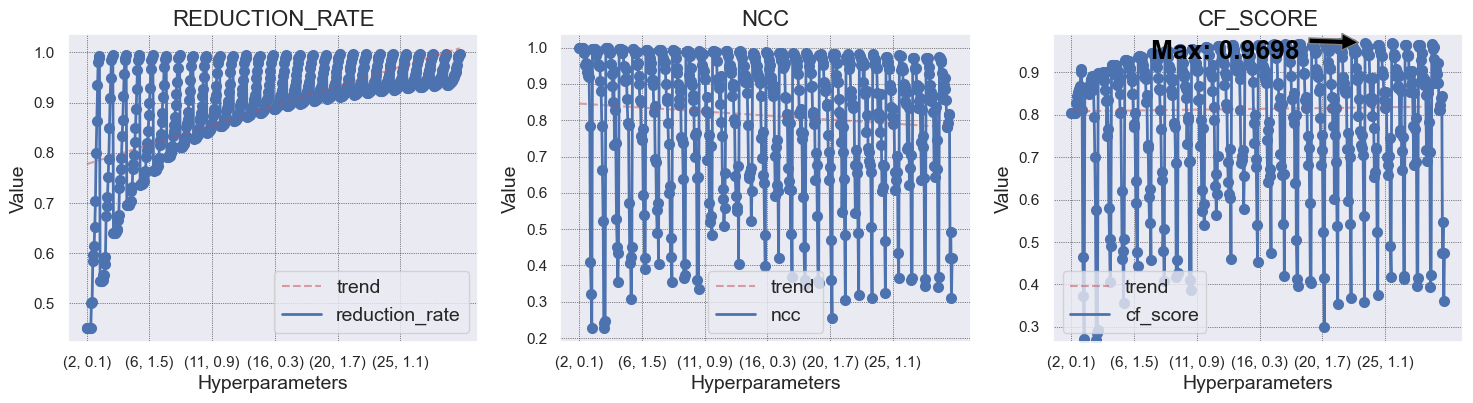

Time to plot the results:  2.7960245609283447
CPU time to plot the results:  1.796875


In [41]:
plot_time_start = time.time()
plot_CPU_start = time.process_time()
plot_multirun_metric_results(result_df=result_df, arrow=True, set_fontsize=14)
plot_CPU_end = time.process_time()
plot_time_end = time.time()

print('Time to plot the results: ', plot_time_end - plot_time_start)
print('CPU time to plot the results: ', plot_CPU_end - plot_CPU_start)

Visualize multirun results with dataset

In [42]:

optimal_time_start = time.time()
optimal_CPU_start = time.process_time()
display_multirun_optimal_values(result_df=result_df)
optimal_CPU_end = time.process_time()
optimal_time_end = time.time()

print("Time to display the optimal values: ", optimal_time_end - optimal_time_start)
print("CPU time to display the optimal values: ", optimal_CPU_end - optimal_CPU_start)

Parameter combinations for  MAX CF_SCORE


         param  reduction_rate  reduction_factor     mse    rmse   nrmse  \
440  (24, 0.1)          0.9224           12.8919  0.6085  0.7801  0.1867   

        mae    psnr     ncc  cf_score  
440  0.1294  30.254  0.9825    0.9698  
Parameter combinations for NEAR  MAX CF_SCORE


         param  reduction_rate  reduction_factor     mse    rmse   nrmse  \
521  (28, 0.2)          0.9336           15.0531  1.1504  1.0726  0.2567   
364  (20, 0.5)          0.9118           11.3396  0.9458  0.9725  0.2328   
262  (15, 0.3)          0.8810            8.4029  0.6337  0.7960  0.1905   
363  (20, 0.4)          0.9102           11.1352  0.9084  0.9531  0.2281   
543  (29, 0.4)          0.9372           15.9222  1.1474  1.0712  0.2564   

        mae     psnr     ncc  cf_score  
521  0.1810  27.4883  0.9666    0.9598  
364  0.1431  28.3388  0.9726    0.9598  
262  0.0907  30.0780  0.9817    0.9598  
363  0.1323  28.5140  0.9737    0.9603  
543  0.1925  2

### Running with the optimal parameters


In [43]:
optimalParam_time_start = time.time()
optimalParam_CPU_start = time.process_time()
optimal_param_list = get_optimal_params(result_df=result_df)
optimalParam_CPU_end = time.process_time()
optimalParam_time_end = time.time()

print("Time to get the optimal params: ", optimalParam_time_end - optimalParam_time_start)
print("CPU time to get the optimal params: ", optimalParam_CPU_end - optimalParam_CPU_start)

print("Best compressor param combination: ", optimal_param_list)

Time to get the optimal params:  0.0010106563568115234
CPU time to get the optimal params:  0.0
Best compressor param combination:  [(24, 0.1)]


In [44]:
optimalCombination_time_start = time.time()
optimalCombination_CPU_start = time.process_time()
points_to_keep, optimal_results_details = run_optimal_combination(optimal_list=optimal_param_list,
                                                          serie_to_compress=sensor_data['Avg_trip_speed'].dropna(),
                                                          model='TAC'
                                                          )
optimalCombination_CPU_end = time.process_time()
optimalCombination_time_end = time.time()

print("Time to run the optimal combination: ", optimalCombination_time_end - optimalCombination_time_start)
print("CPU time to run the optimal combination: ", optimalCombination_CPU_end - optimalCombination_CPU_start)

Time to run the optimal combination:  0.09111905097961426
CPU time to run the optimal combination:  0.0625


In [46]:
print_run_details(optimal_results_details)

POINTS:
 - total checked:  30889
 - total kept:  1199
 - percentage discaded:  96.12 %

POINT EVALUATION TIMES (ms): 
 - mean:  0.002070380042951488
 - std:  0.045456492027483676
 - median:  0.0
 - max:  1.7080307006835938
 - min:  0.0
 - total:  63.951969146728516

RUN TIME (ms):
 - total:  77.0435


### Evaluating the results

Set up the evaluation dataframe

In [47]:
evaluation_time_start = time.time()
evaluation_CPU_start = time.process_time()
evaluation_df = create_eval_df(original=sensor_data['Avg_trip_speed'].dropna(), flag=points_to_keep)
evaluation_CPU_end = time.process_time()
evaluation_time_end = time.time()

print("Time to create the evaluation df: ", evaluation_time_end - evaluation_time_start)
print("CPU time to create the evaluation df: ", evaluation_CPU_end - evaluation_CPU_start)

evaluation_df.info()

Time to create the evaluation df:  0.012647390365600586
CPU time to create the evaluation df:  0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889 entries, 0 to 30888
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   original      30889 non-null  float64
 1   compressed    1199 non-null   float64
 2   decompressed  30889 non-null  float64
dtypes: float64(3)
memory usage: 724.1 KB


In [48]:
evaluation_df.head()

,original,compressed,decompressed
0,1.17,1.17,1.17000
1,1.26,NaN,1.28125
2,1.26,NaN,1.39250
3,1.22,NaN,1.50375
4,1.18,NaN,1.61500


Evaluation performance

In [49]:

report_time_start = time.time()
report_CPU_start = time.process_time()

# create dictionary report 
report = get_compression_report(
    original=evaluation_df['original'],
    compressed=evaluation_df['compressed'],
    decompressed=evaluation_df['decompressed'],
    cf_score_beta=2
)

report_CPU_end = time.process_time()
report_time_end = time.time()

print("Time to create the report: ", report_time_end - report_time_start)
print("CPU time to create the report: ", report_CPU_end - report_CPU_start)

Time to create the report:  0.06758975982666016
CPU time to create the report:  0.046875


In [52]:
printReport_time_start = time.time()
printReport_CPU_start = time.process_time()

print_compression_report(
    report, 
    model_name=model_name,
    cf_score_beta=2,
    model_params=optimal_param_list
)

printReport_CPU_end = time.process_time()
printReport_time_end = time.time()

print("\n\n")
print("Time to process the report: ", printReport_time_end - printReport_time_start)
print("CPU time to process the report: ", printReport_CPU_end - printReport_CPU_start)

# Save the report to a dictionary
exp_compression_report[model_name] = report


# RUN INFO #
- Model:  TAC_TripSpeed_data
- Optimal Params:  [(24, 0.1)]
- CF-Score Beta:  2

# RESULTS #

SAMPLES NUMBER reduction
- Original length:  30889  samples
- Reduced length:  1199  samples
- Samples reduced by a factor of 25.76 times
- Sample reduction rate: 96.12%

FILE SIZE compression
- Original size:  385549  Bytes
- Compressed size:  14974  Bytes
- file compressed by a factor of 25.75 times
- file compression rate: 96.12%

METRICS
- MSE:  0.622
- RMSE:  0.7886
- NRMSE:  0.1888
- MAE:  0.1384
- PSNR:  30.1591
- NCC:  0.9821
- CF-Score:  0.9778



Time to process the report:  0.00029087066650390625
CPU time to process the report:  0.0


In [53]:
stats_time_start = time.time()
stats_CPU_start = time.process_time()
model_stats = calc_statistics(evaluation_df)
stats_CPU_end = time.process_time()
stats_time_end = time.time()

print("Time to calculate the statistics: ", stats_time_end - stats_time_start)
print("CPU time to calculate the statistics: ", stats_CPU_end - stats_CPU_start)

# save the statistics to a dictionary
exp_statistics_report[model_name] = model_stats
model_stats

Time to calculate the statistics:  0.02361011505126953
CPU time to calculate the statistics:  0.0


,min,max,mean,median,std,skewness,kurtosis
original,0.69,26.09,16.734863,17.030000,4.178219,-0.632882,0.796365
decompressed,1.11,26.08,16.722576,17.023077,4.088868,-0.538119,0.438040


### Creating the model visualizations

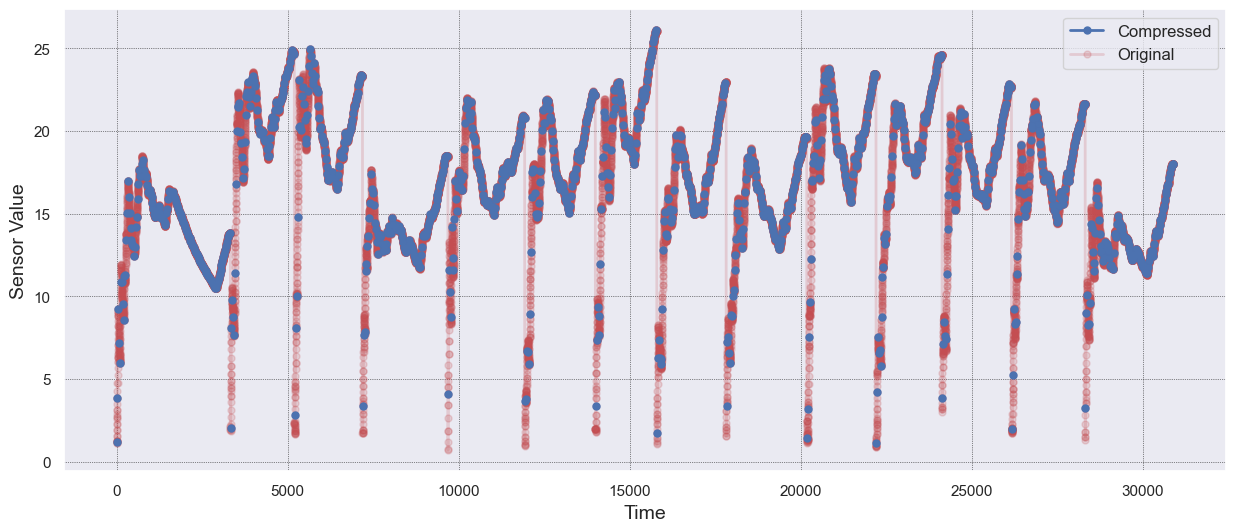

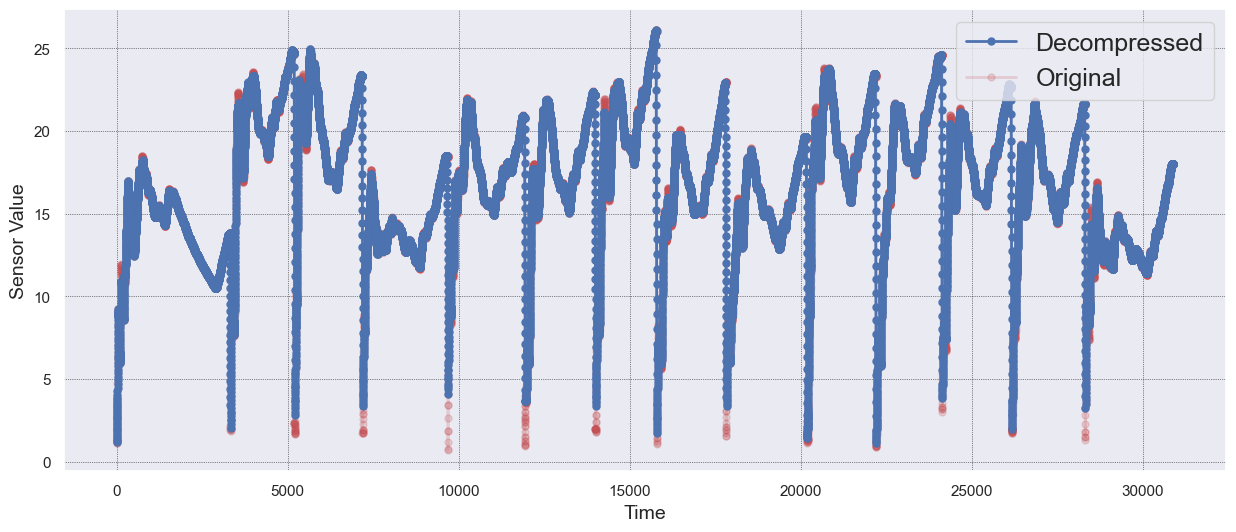

In [54]:
# plot the curves comparison (original vs compressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)


# plot the curves comparison (original vs decompressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True,
    set_fontsize=18,
    loc='upper right'
)

c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(processed, label=processe

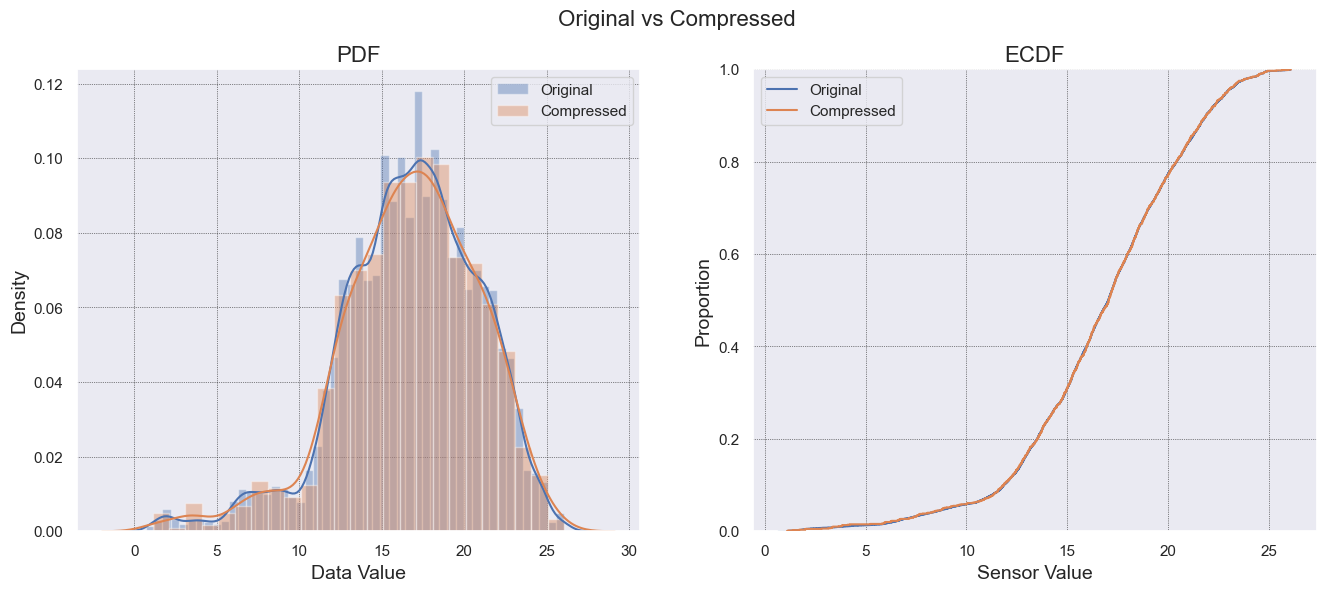

c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(processed, label=processe

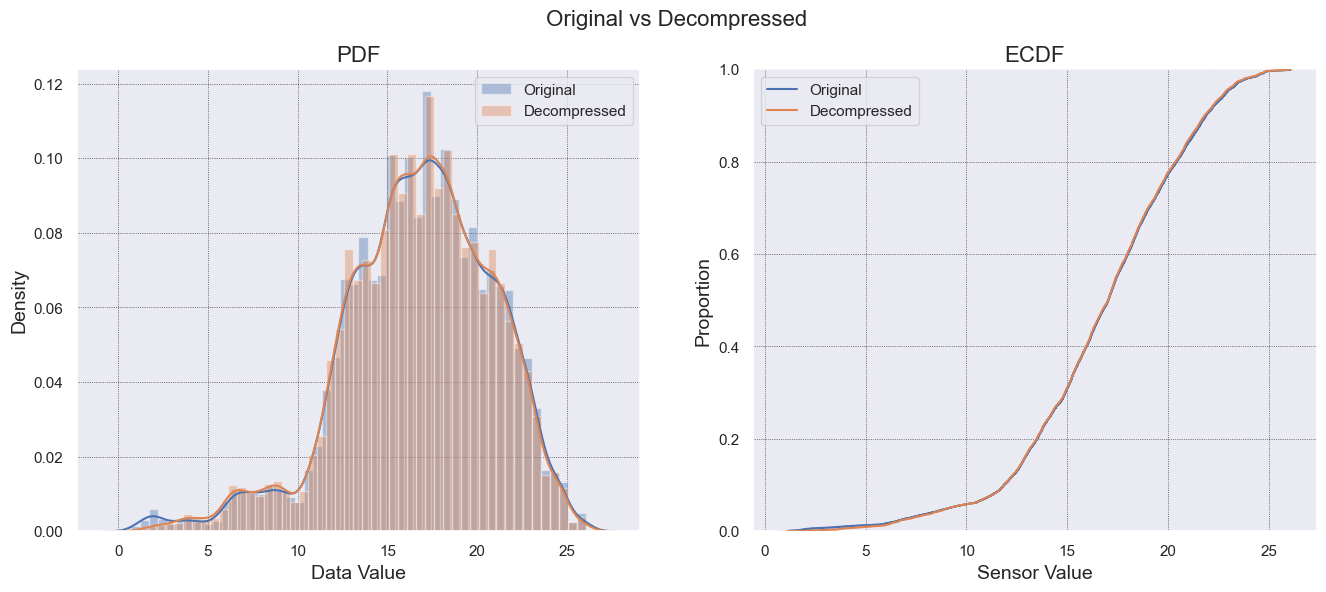

In [55]:
#compressed_dist_path = f'./results/{exp_number}/cf{exp_beta}_run/{model_name}__DIST_orig-v-comp.png'
#decompressed_dist_path = f'./results/{exp_number}/cf{exp_beta}_run/{model_name}__DIST_orig-v-decomp.png'

plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)
plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True
)

# Second Experiment

In [86]:
new_data = df['Average trip speed(whilst stopped or moving)(km/h)']

In [87]:
sensor_data = pd.DataFrame({'Time': range(1, len(new_data) + 1), 'Avg_trip_speed': new_data })

In [88]:
sensor_data.describe()

,Time,Avg_trip_speed
count,30889.000000,30889.000000
mean,15445.000000,16.734863
std,8917.030569,4.178219
min,1.000000,0.690000
25%,7723.000000,14.170000
50%,15445.000000,17.030000
75%,23167.000000,19.700000
max,30889.000000,26.090000


In [90]:
# first create a model name (not necessary but useful for saving)
model_name = 'AutoTAC_TripSpeed_data'

# Create the params dictionary (actually necessary)
params = {
    'window_size': np.arange(2, 30, 1),
}

# Clock time to create the param combination
combination_time_start = time.time()
# CPU time to create the param combination
combination_CPU_start = time.process_time()
param_combination = create_param_combinations(params)
combination_CPU_end = time.process_time()
combination_time_end = time.time()

print('Time to create the param combination: ', combination_time_end - combination_time_start)
print('CPU time to create the param combination: ', combination_CPU_end - combination_CPU_start)

Time to create the param combination:  0.0009882450103759766
CPU time to create the param combination:  0.0


In [91]:
list_time_start = time.time()
list_CPU_start = time.process_time()
compressor_list = [AutoTAC(window_size=window) for window in param_combination]
list_CPU_end = time.process_time()
list_time_end = time.time()

print('Time to create the compressor list: ', list_time_end - list_time_start)
print('CPU time to create the compressor list: ', list_CPU_end - list_CPU_start)

print(len(compressor_list), 'compressors created')

Time to create the compressor list:  0.000997304916381836
CPU time to create the compressor list:  0.0
28 compressors created


In [92]:
result_df_time_start = time.time()
result_df_CPU_start = time.process_time()
result_df = run_multiple_instances(compressor_list=compressor_list, 
                                param_list=param_combination,
                                series_to_compress=sensor_data['Avg_trip_speed'].dropna(),
                                cf_score_beta=2
                                )
result_df_CPU_end = time.process_time()
result_df_time_end = time.time()
 
print('Time to run the compressors: ', result_df_time_end - result_df_time_start)
print('CPU time to run the compressors: ', result_df_CPU_end - result_df_CPU_start)

result_df.head(8)

Time to run the compressors:  5.831985235214233
CPU time to run the compressors:  5.296875


,param,reduction_rate,reduction_factor,mse,rmse,nrmse,mae,psnr,ncc,cf_score
0,2,0.7257,3.6460,0.1619,0.4023,0.0963,0.0257,36.0049,0.9954,0.9266
1,3,0.7749,4.4425,0.2113,0.4597,0.1100,0.0325,34.8474,0.9940,0.9408
2,4,0.8249,5.7096,0.6420,0.8013,0.1918,0.0627,30.0213,0.9815,0.9456
3,5,0.8538,6.8384,0.8381,0.9155,0.2191,0.0825,28.8639,0.9758,0.9487
4,6,0.8740,7.9345,0.3969,0.6300,0.1508,0.0578,32.1096,0.9886,0.9633
5,7,0.8881,8.9352,0.4323,0.6575,0.1574,0.0637,31.7385,0.9876,0.9659
6,8,0.9012,10.1242,0.9547,0.9771,0.2339,0.1007,28.2978,0.9724,0.9573
7,9,0.9112,11.2651,0.9486,0.9740,0.2331,0.1041,28.3257,0.9725,0.9596


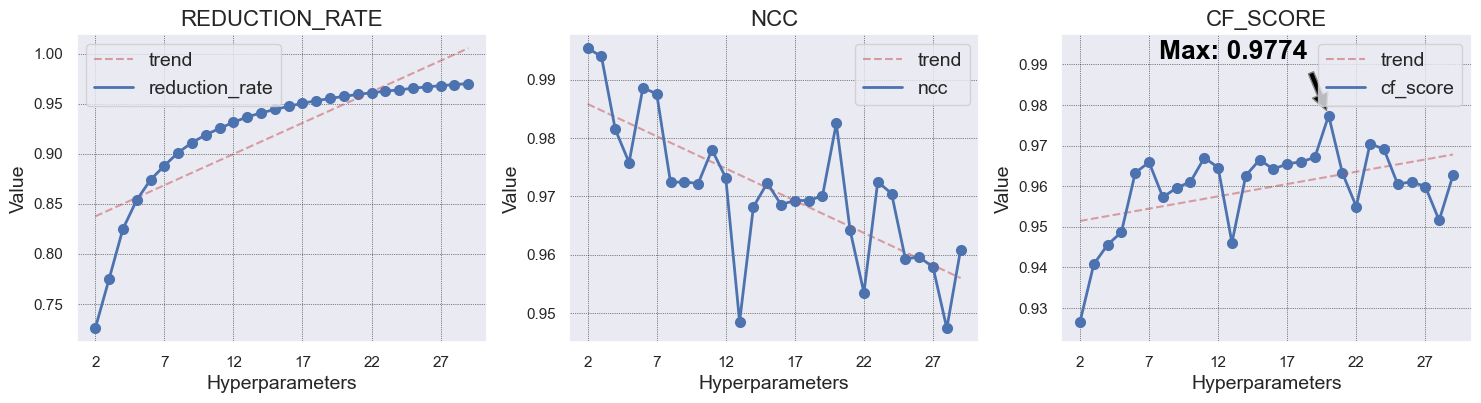

Time to plot the results:  0.5418810844421387
CPU time to plot the results:  0.484375


In [93]:
plot_time_start = time.time()
plot_CPU_start = time.process_time()
plot_multirun_metric_results(result_df=result_df, arrow=True, set_fontsize=14)
plot_CPU_end = time.process_time()
plot_time_end = time.time()

print('Time to plot the results: ', plot_time_end - plot_time_start)
print('CPU time to plot the results: ', plot_CPU_end - plot_CPU_start)

In [94]:
optimal_time_start = time.time()
optimal_CPU_start = time.process_time()
display_multirun_optimal_values(result_df=result_df)
optimal_CPU_end = time.process_time()
optimal_time_end = time.time()

print("\n\n")
print("Time to display the optimal values: ", optimal_time_end - optimal_time_start)
print("CPU time to display the optimal values: ", optimal_CPU_end - optimal_CPU_start)

Parameter combinations for  MAX CF_SCORE


    param  reduction_rate  reduction_factor     mse    rmse   nrmse     mae  \
18     20          0.9574           23.4897  0.6059  0.7784  0.1863  0.1345   

       psnr     ncc  cf_score  
18  30.2726  0.9825    0.9774  
Parameter combinations for NEAR  MAX CF_SCORE


    param  reduction_rate  reduction_factor     mse    rmse   nrmse     mae  \
22     24          0.9639           27.7031  1.0179  1.0089  0.2415  0.1758   
21     23          0.9626           26.7437  0.9468  0.9731  0.2329  0.1699   

       psnr     ncc  cf_score  
22  28.0195  0.9705    0.9691  
21  28.3340  0.9725    0.9705  



Time to display the optimal values:  0.006518125534057617
CPU time to display the optimal values:  0.0


In [95]:
optimalParam_time_start = time.time()
optimalParam_CPU_start = time.process_time()
optimal_param_list = get_optimal_params(result_df=result_df)
optimalParam_CPU_end = time.process_time()
optimalParam_time_end = time.time()

print("Time to get the optimal params: ", optimalParam_time_end - optimalParam_time_start)
print("CPU time to get the optimal params: ", optimalParam_CPU_end - optimalParam_CPU_start)

print("Best compressor param combination: ", optimal_param_list)

Time to get the optimal params:  0.0021576881408691406
CPU time to get the optimal params:  0.0
Best compressor param combination:  [20]


In [98]:
optimalCombination_time_start = time.time()
optimalCombination_CPU_start = time.process_time()

compressor = AutoTAC(window_size=20, save_metrics=False)

points_to_keep, optimal_run_details = run_single_online(compressor, sensor_data['Avg_trip_speed'].dropna())

optimalCombination_CPU_end = time.process_time()
optimalCombination_time_end = time.time()

print("Time to run the optimal combination: ", optimalCombination_time_end - optimalCombination_time_start)
print("CPU time to run the optimal combination: ", optimalCombination_CPU_end - optimalCombination_CPU_start)

Time to run the optimal combination:  0.15206241607666016
CPU time to run the optimal combination:  0.140625


In [99]:
print_run_details(optimal_run_details)

POINTS:
 - total checked:  30889
 - total kept:  1315
 - percentage discaded:  95.74 %

POINT EVALUATION TIMES (ms): 
 - mean:  0.004180518385004667
 - std:  0.06451998952811641
 - median:  0.0
 - max:  1.5299320220947266
 - min:  0.0
 - total:  129.13203239440918

RUN TIME (ms):
 - total:  136.9727


In [100]:
evaluation_time_start = time.time()
evaluation_CPU_start = time.process_time()
evaluation_df = create_eval_df(original=sensor_data['Avg_trip_speed'].dropna(), flag=points_to_keep)
evaluation_CPU_end = time.process_time()
evaluation_time_end = time.time()

print("Time to create the evaluation df: ", evaluation_time_end - evaluation_time_start)
print("CPU time to create the evaluation df: ", evaluation_CPU_end - evaluation_CPU_start)

evaluation_df.info()

Time to create the evaluation df:  0.01117706298828125
CPU time to create the evaluation df:  0.015625
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30889 entries, 0 to 30888
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   original      30889 non-null  float64
 1   compressed    1315 non-null   float64
 2   decompressed  30889 non-null  float64
dtypes: float64(3)
memory usage: 724.1 KB


In [102]:
report_time_start = time.time()
report_CPU_start = time.process_time()

# create dictionary report 
report = get_compression_report(
    original=evaluation_df['original'],
    compressed=evaluation_df['compressed'],
    decompressed=evaluation_df['decompressed'],
    cf_score_beta=2
)

report_CPU_end = time.process_time()
report_time_end = time.time()

print("Time to create the report: ", report_time_end - report_time_start)
print("CPU time to create the report: ", report_CPU_end - report_CPU_start)

Time to create the report:  0.054051876068115234
CPU time to create the report:  0.046875


In [103]:
printReport_time_start = time.time()
printReport_CPU_start = time.process_time()

print_compression_report(
    report, 
    model_name=model_name,
    cf_score_beta=2,
    model_params=optimal_param_list
)

printReport_CPU_end = time.process_time()
printReport_time_end = time.time()

print("\n\n")
print("Time to process the report: ", printReport_time_end - printReport_time_start)
print("CPU time to process the report: ", printReport_CPU_end - printReport_CPU_start)

# Save the report to a dictionary
exp_compression_report[model_name] = report


# RUN INFO #
- Model:  AutoTAC_Acceleration_data
- Optimal Params:  [20]
- CF-Score Beta:  2

# RESULTS #

SAMPLES NUMBER reduction
- Original length:  30889  samples
- Reduced length:  1315  samples
- Samples reduced by a factor of 23.49 times
- Sample reduction rate: 95.74%

FILE SIZE compression
- Original size:  385549  Bytes
- Compressed size:  16426  Bytes
- file compressed by a factor of 23.47 times
- file compression rate: 95.74%

METRICS
- MSE:  0.6059
- RMSE:  0.7784
- NRMSE:  0.1863
- MAE:  0.1345
- PSNR:  30.2726
- NCC:  0.9825
- CF-Score:  0.9774



Time to process the report:  0.0006802082061767578
CPU time to process the report:  0.0


In [104]:
stats_time_start = time.time()
stats_CPU_start = time.process_time()
model_stats = calc_statistics(evaluation_df)
stats_CPU_end = time.process_time()
stats_time_end = time.time()

print("Time to calculate the statistics: ", stats_time_end - stats_time_start)
print("CPU time to calculate the statistics: ", stats_CPU_end - stats_CPU_start)

# save the statistics to a dictionary
exp_statistics_report[model_name] = model_stats
model_stats

Time to calculate the statistics:  0.008761167526245117
CPU time to calculate the statistics:  0.0


,min,max,mean,median,std,skewness,kurtosis
original,0.69,26.09,16.734863,17.030000,4.178219,-0.632882,0.796365
decompressed,1.00,26.01,16.718628,17.019524,4.098948,-0.553283,0.506278


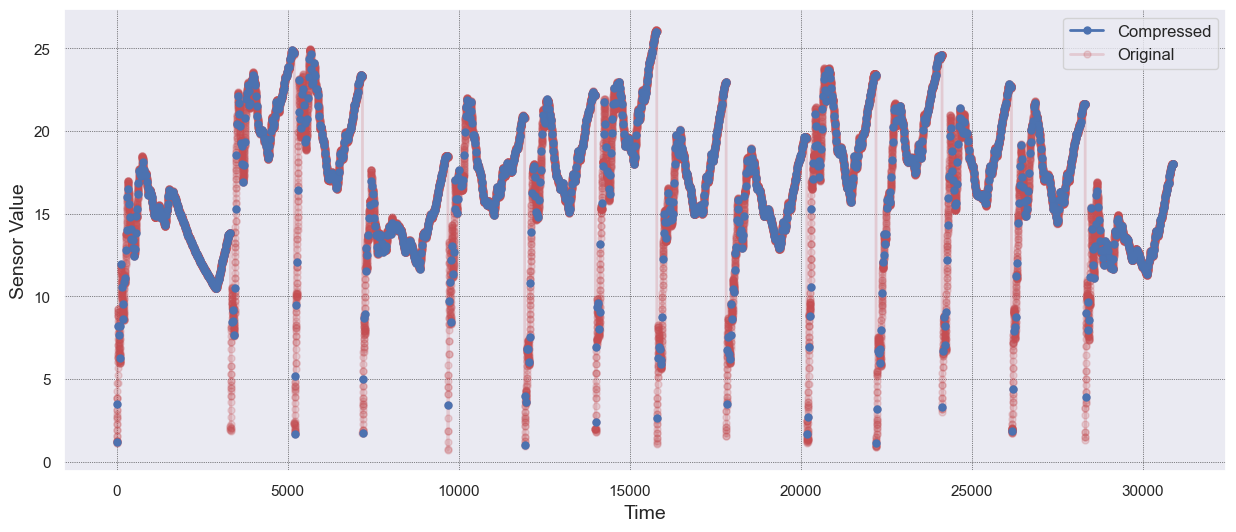

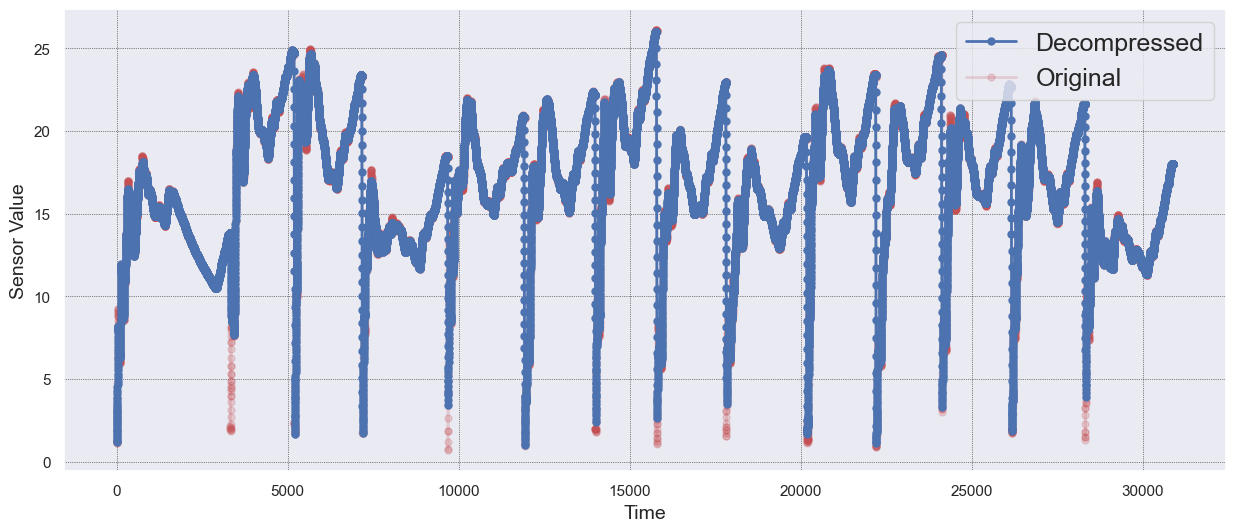

In [105]:
# plot the curves comparison (original vs compressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)


# plot the curves comparison (original vs decompressed)
plot_curve_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True,
    set_fontsize=18,
    loc='upper right'
)

c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(processed, label=processe

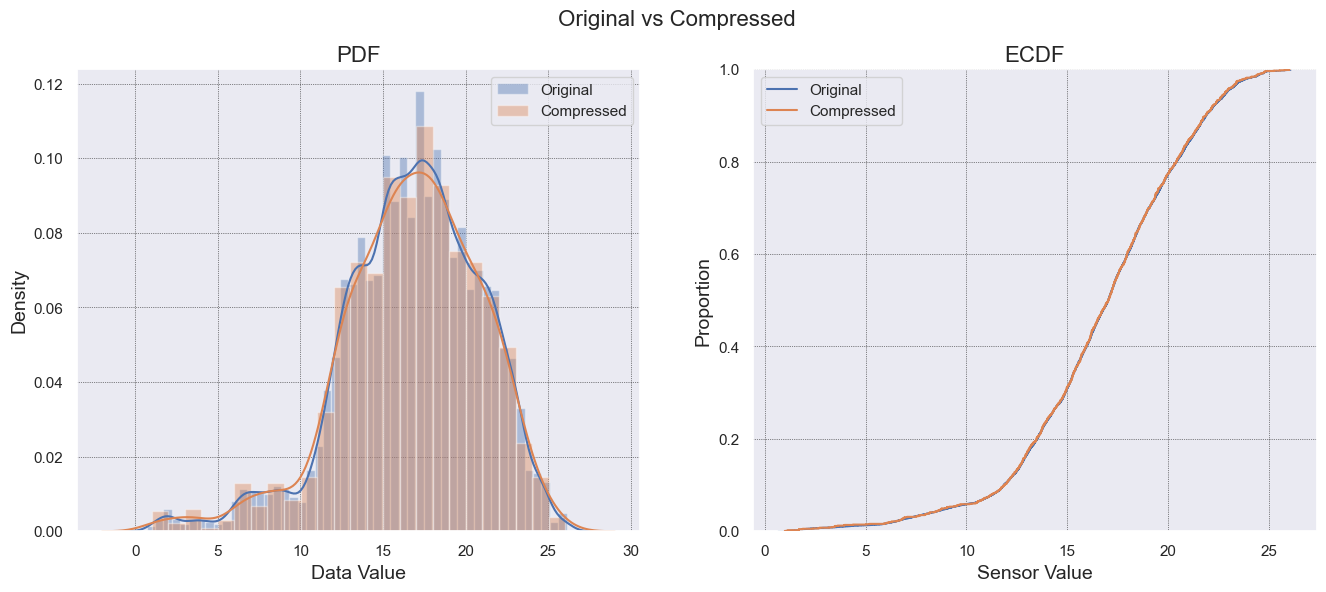

c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:88: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(reference, label=reference_name, ax=ax[0])
c:\Users\Miguel\Documents\GitHub\TACpy\conect2py\utils\plots.py:89: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(processed, label=processe

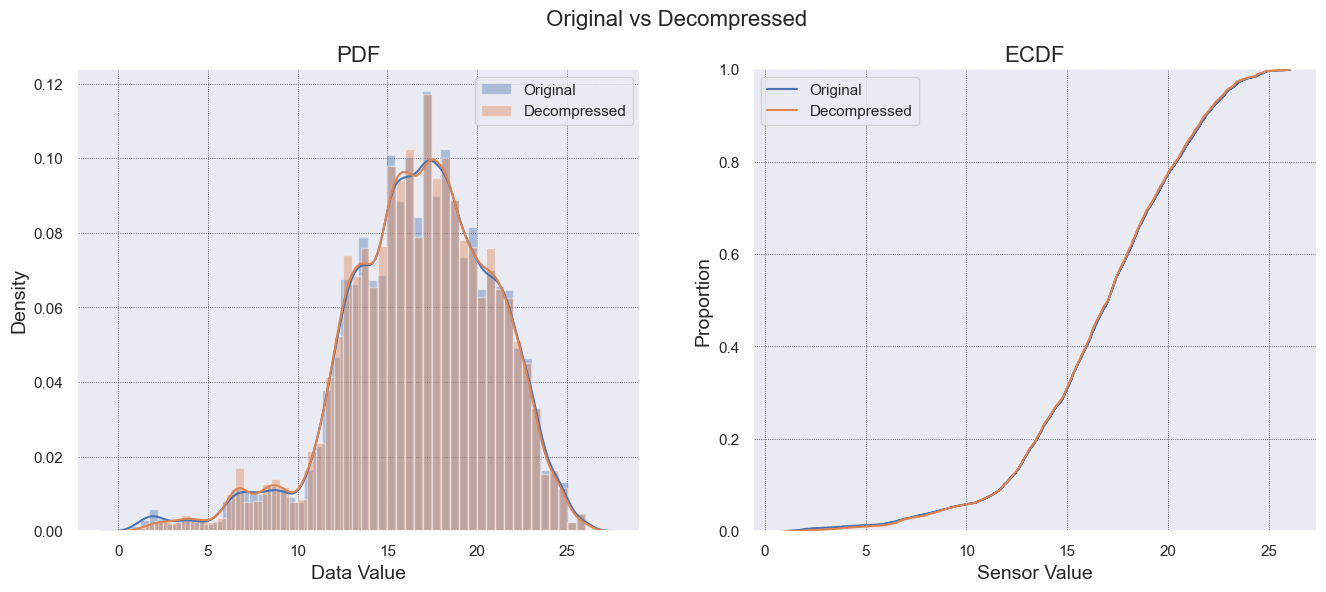

In [106]:
plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.compressed,
    show=True
)
plot_dist_comparison(
    evaluation_df.original,
    evaluation_df.decompressed,
    show=True
)

# Third Experiment

In [107]:
data = df['Voltage (Control Module)(V)']

In [108]:
sensor_data = pd.DataFrame({'Time': range(1, len(data) + 1), 'Voltage (Control Module)(V)': data })


In [109]:
sensor_data.describe()

,Time,Voltage (Control Module)(V)
count,30889.000000,30889.000000
mean,15445.000000,14.107459
std,8917.030569,0.195311
min,1.000000,12.700000
25%,7723.000000,14.060000
50%,15445.000000,14.140000
75%,23167.000000,14.220000
max,30889.000000,14.620000


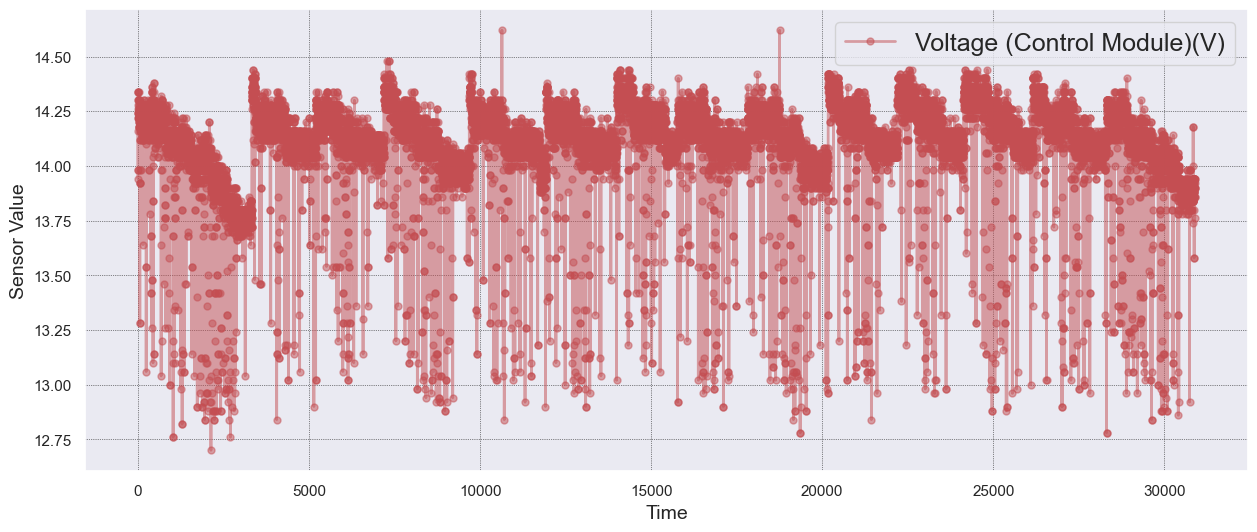

In [110]:
sns.set()
fig, ax = plt.subplots(1, 1, figsize=(15,6))
ax.clear()
# define the curve1 and curve2 based on the params
curve1 = sensor_data['Voltage (Control Module)(V)']
curve1_name = 'Voltage (Control Module)(V)'
# plot the 2 curves
ax.plot(curve1, color='r', marker='o', linewidth=2, markersize=5, zorder=1, alpha=0.5, label=curve1_name)
#fig.suptitle('Average trip speed Visualization', fontsize=16)
ax.legend(fontsize=18, loc='upper right')
ax.set_ylabel('Sensor Value', fontsize=14)
ax.set_xlabel('Time', fontsize=14)
plt.grid(color='k', linestyle=':', linewidth=0.5)

The ideia here is to simulate TAC execution in real time, as you receive the data, and then evaluate the performance of the model.

In this example we will use a small window of anomalies and try a more sensitive model to see how the model performs.

In [151]:
points_to_keep = []
time_per_point = []

tac = TAC(window_threshold=5, m=0.2)


In [152]:
total_start = time.time()
for data in sensor_data['Voltage (Control Module)(V)'].dropna():
    start = time.time() 
    should_keep = tac.check_point(data)
    end = time.time()
    points_to_keep.append(should_keep)
    time_per_point.append(round((end - start)*1000, 4))
total_end = time.time()

total_time = total_end - total_start

In [153]:
 # compile the run details
run_details = {
    'times': {
        'total': round(total_time*1000, 4),
        'iteration_mean': np.mean(time_per_point) * 1000, 
        'iteration_std': np.std(time_per_point) * 1000, 
        'iteration_median': np.median(time_per_point) * 1000,
        'iteration_max': np.max(time_per_point) * 1000, 
        'iteration_min': np.min(time_per_point) * 1000,
        'iteration_total': np.sum(time_per_point) * 1000, 
        'all_iterations': time_per_point
    },
    'points': {
        'total_checked': len(points_to_keep),
        'total_kept': np.sum(points_to_keep),
        'total_discarded': len(points_to_keep) - np.sum(points_to_keep),
        'all_kept': points_to_keep
    } 
}


In [154]:
print_run_details(run_details)

POINTS:
 - total checked:  30889
 - total kept:  8731
 - percentage discaded:  71.73 %

POINT EVALUATION TIMES (ms): 
 - mean:  1.4556800155395124
 - std:  63.13901822630909
 - median:  0.0
 - max:  8819.1
 - min:  0.0
 - total:  44964.5

RUN TIME (ms):
 - total:  62.4325


In [155]:
eval_df = create_eval_df(original=sensor_data['Voltage (Control Module)(V)'].dropna(), flag=points_to_keep)

In [156]:
report = get_compression_report(
    original=eval_df['original'],
    compressed=eval_df['compressed'],
    decompressed=eval_df['decompressed'],
    cf_score_beta=2
)

In [160]:
print_compression_report(
    report, 
    model_name='TAC_Voltage',
    cf_score_beta=2,
    model_params=[(5, 0.2)]
)


# RUN INFO #
- Model:  TAC_Voltage
- Optimal Params:  [(5, 0.2)]
- CF-Score Beta:  2

# RESULTS #

SAMPLES NUMBER reduction
- Original length:  30889  samples
- Reduced length:  8731  samples
- Samples reduced by a factor of 3.54 times
- Sample reduction rate: 71.73%

FILE SIZE compression
- Original size:  384831  Bytes
- Compressed size:  108833  Bytes
- file compressed by a factor of 3.54 times
- file compression rate: 71.72%

METRICS
- MSE:  0.0242
- RMSE:  0.1556
- NRMSE:  0.7968
- MAE:  0.057
- PSNR:  21.8244
- NCC:  0.6507
- CF-Score:  0.663


In [161]:
model_stats = calc_statistics(eval_df)
model_stats

,min,max,mean,median,std,skewness,kurtosis
original,12.70,14.62,14.107459,14.14,0.195311,-2.960288,13.002997
decompressed,12.76,14.62,14.109951,14.13,0.174160,-2.409471,10.042278


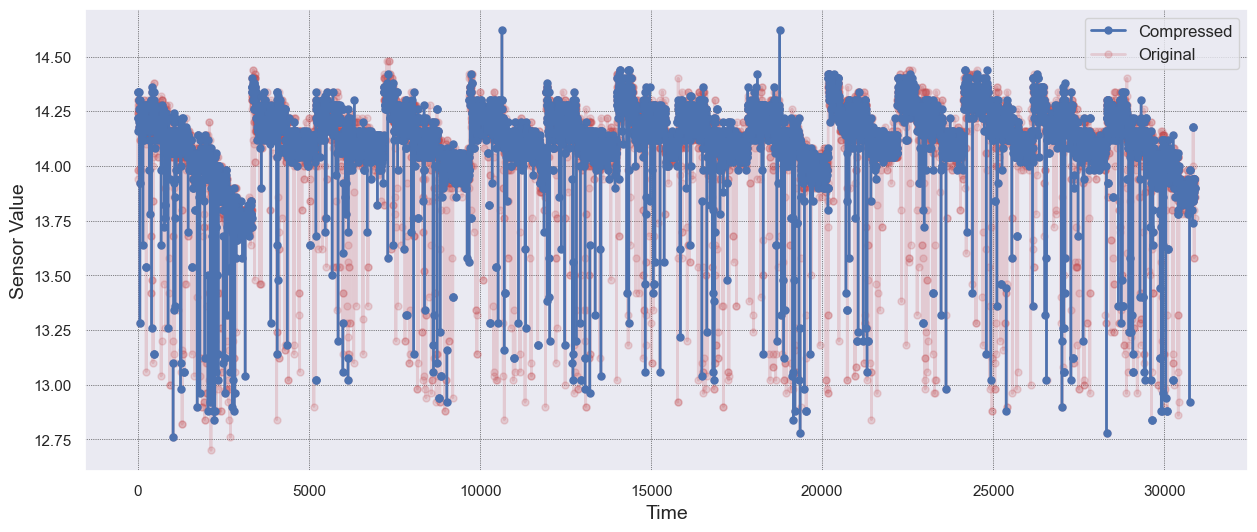

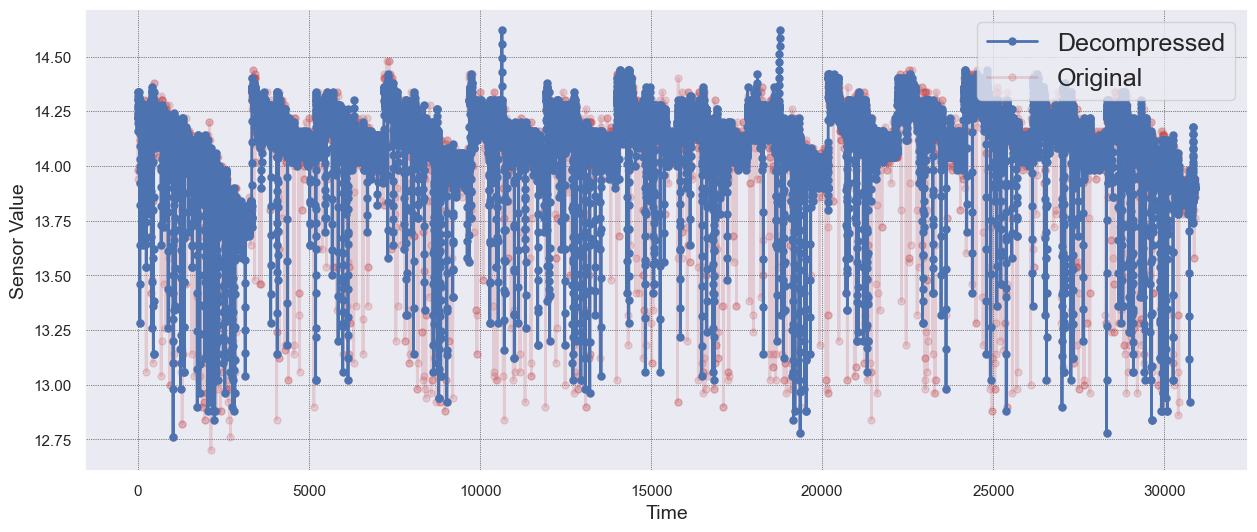

In [162]:
# plot the curves comparison (original vs compressed)
plot_curve_comparison(
    eval_df.original,
    eval_df.compressed,
    show=True
)


# plot the curves comparison (original vs decompressed)
plot_curve_comparison(
    eval_df.original,
    eval_df.decompressed,
    show=True,
    set_fontsize=18,
    loc='upper right'
)